# Header

* set up the Python environment and load some helper functions

In [ ]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import missingno as msno
from sklearn import metrics
from sklearn.preprocessing import scale, StandardScaler, normalize
from sklearn import decomposition
import pickle
from collections import Counter

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.1f}'.format


%matplotlib inline

## task 1 - data analysis

## Data import and cleaning

In [2]:
data = pd.read_csv('./data.csv',encoding='ISO-8859-1')

In [3]:
data.shape

(541909, 8)

The data consists of 8 columns and 541909 rows.

In [4]:
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.5,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.4,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.8,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.4,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.4,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.7,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.2,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.9,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.9,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.7,13047.0,United Kingdom


A cursory check for missing data:

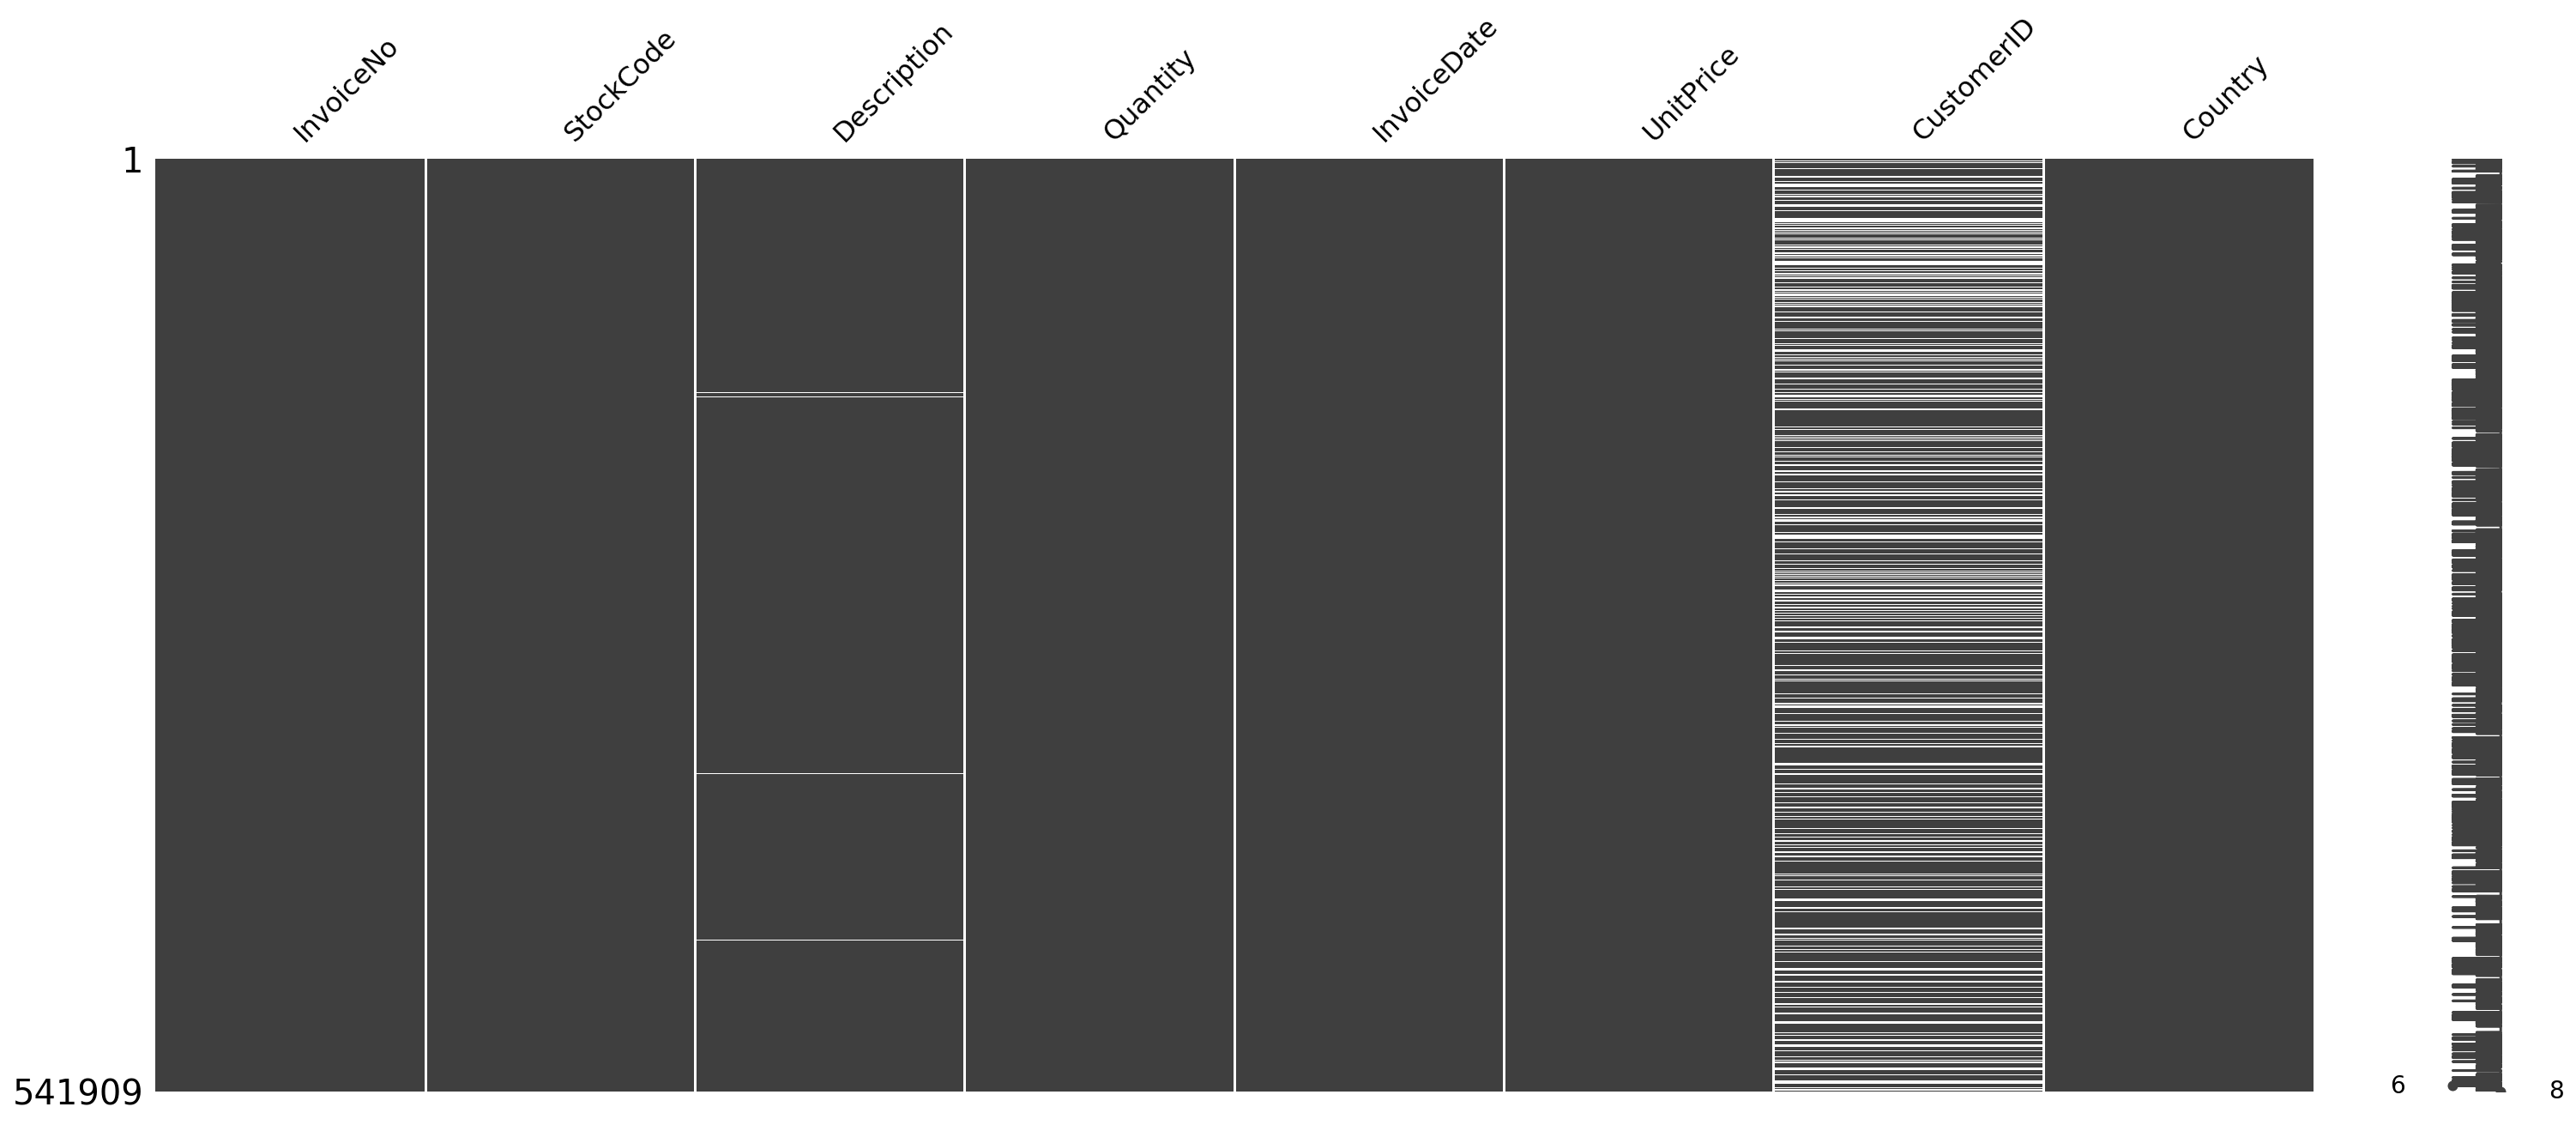

In [5]:
msno.matrix(data);

The dataset is missing some Description and customer ID data entries.

In [6]:
null_data = data[data.isnull().any(axis=1)]
null_data.shape

(135080, 8)

In [7]:
null_data_frac = null_data.shape[0]/data.shape[0]*100
null_data_frac

24.926694334288598

25% of the data contains missing values, which the figure above indicates is mostly nan values in CustomerID

## Exploratory data analysis

In [8]:
data = data.sort_values('Quantity', ascending=False)
data.head(11)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.1,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.0,12346.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.0,13256.0,United Kingdom
74614,542504,37413,NaN,5568,1/28/2011 12:03,0.0,nan,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.2,12901.0,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,5/27/2011 10:52,0.7,13135.0,United Kingdom
220843,556231,85123A,?,4000,6/9/2011 15:04,0.0,nan,United Kingdom
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2/22/2011 10:43,0.8,18087.0,United Kingdom
270885,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,7/19/2011 17:04,0.1,14609.0,United Kingdom
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,4/18/2011 13:20,2.1,15749.0,United Kingdom


The top 10 most popular items are sold in/to the UK. Apparently paper craft little birdie is very popular, along with medium ceramic top storage jar. I will remove the items with 'NaN' descriptor. These entries associated with nan CustomerID entries and 131 lower case descriptions which describe problems with the orders and no details of the item ordered. In addition, the data for United Kingdom contains negative values associated with negative UnitPrice values. Removing the rows containing NaN values therefore cleans several issues that complicate this analysis in the absence of the data owner.

In [9]:
data = data.dropna()

In [10]:
data.shape # 541909 - 406829 = dropped 135,080 entries

(406829, 8)

In [11]:
# in addition I will check for duplicate entries and remove those
data.drop_duplicates(inplace = True)

In [12]:
data.shape

(401604, 8)

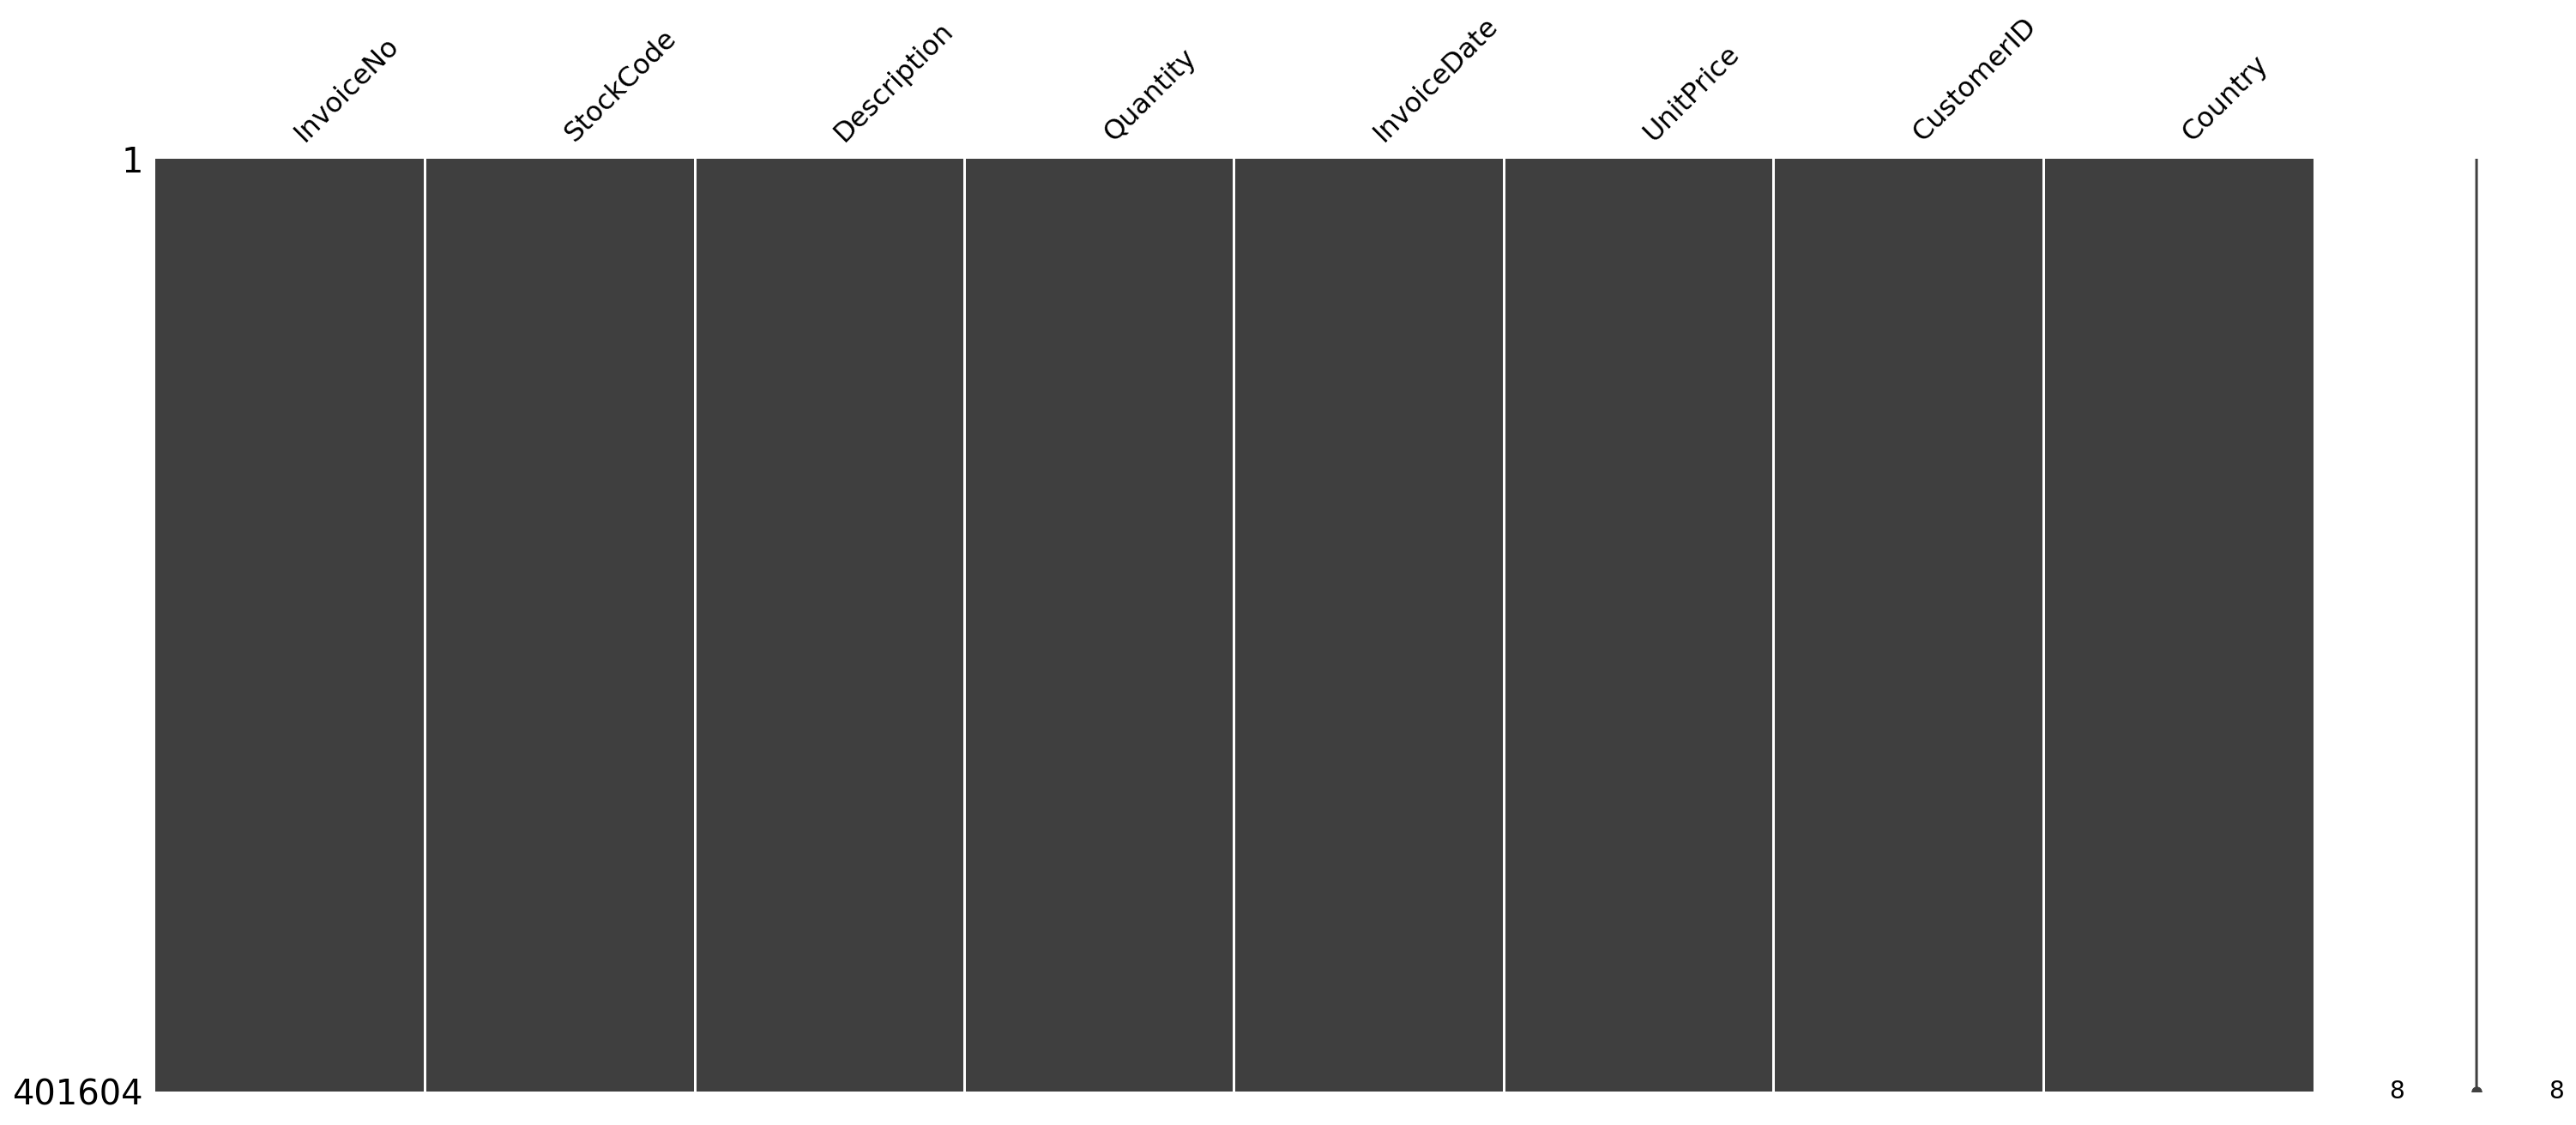

In [13]:
msno.matrix(data);

We now have no missing values and have removed assumed erroneous results and duplicates.

### Further exploration

How many unique descriptors are there in "Descriptions"?

In [14]:
# general clean up of Description column to remove any heading or trailing white space
data['Description'] = data['Description'].str.strip()
descriptors = pd.unique(data['Description'].values.ravel()).tolist()
print('There are',len(descriptors), 'unique descriptors in the Descriptions column.')

There are 3885 unique descriptors in the Descriptions column.


In [15]:
descriptors2 = []
for i in range(0,len(descriptors),1):
    text = str(descriptors[i])
    if text == text.upper():
        descriptors2.append(text)
        
print('There are', len(descriptors2), 'all caps descriptors.')

There are 3862 all caps descriptors.


In [16]:
# from inspection of the baskets below I identified 3 problem descriptors that need to be followed up.
additional_problem_list = ['damages/credits from ASOS.','incorrectly credited C550456 see 47', 'mystery! Only ever imported 1800']

In [17]:
# remove additional erroneous rows
data = data[~data['Description'].isin(additional_problem_list)]

In [18]:
data.shape

(401604, 8)

In [19]:
InvoiceNo = pd.unique(data['InvoiceNo'].values.ravel()).tolist()
print('There are', len(InvoiceNo), 'unique invoice numbers in the dataset.')

There are 22190 unique invoice numbers in the dataset.


#### Group by country

In [20]:
by_country = data.groupby('Country')
by_country.describe()

CustomerID                                         \
                          count    mean    std     min     25%     50%   
Country                                                                  
Australia                1258.0 12464.7  438.0 12386.0 12415.0 12415.0   
Austria                   401.0 12521.5  216.5 12358.0 12360.0 12374.0   
Bahrain                    17.0 12354.5    0.9 12353.0 12355.0 12355.0   
Belgium                  2069.0 12430.3  110.0 12361.0 12383.0 12407.0   
Brazil                     32.0 12769.0    0.0 12769.0 12769.0 12769.0   
Canada                    151.0 17321.1  521.5 15388.0 17444.0 17444.0   
Channel Islands           757.0 14888.1  142.8 14442.0 14930.0 14936.0   
Cyprus                    611.0 12405.4  200.6 12359.0 12359.0 12370.0   
Czech Republic             30.0 12781.0    0.0 12781.0 12781.0 12781.0   
Denmark                   389.0 12536.6  421.9 12367.0 12406.0 12412.0   
EIRE                     7475.0 14748.7  314.5 14016.0 14911.0 14911.0   
European Community         61.0 15108.0    0.0 15108.0 15108.0 15108.0   
Finland                   695.0 12517.0  122.4 12348.0 12428.0 12428.0   
France                   8475.0 12677.5  275.4 12413.0 12571.0 12674.0   
Germany                  9480.0 12645.8  307.9 12426.0 12480.0 12592.0   
Greece                    146.0 13757.4 1749.6 12478.0 12717.0 12717.0   
Iceland                   182.0 12347.0    0.0 12347.0 12347.0 12347.0   
Israel                    247.0 12659.6   57.6 12512.0 12653.0 12688.0   
Italy                     803.0 12648.4  437.4 12349.0 12578.0 12584.0   
Japan                     358.0 12757.8   13.6 12753.0 12753.0 12753.0   
Lebanon                    45.0 12764.0    0.0 12764.0 12764.0 12764.0   
Lithuania                  35.0 15332.0    0.0 15332.0 15332.0 15332.0   
Malta                     127.0 16996.0 1127.5 15480.0 15480.0 17828.0   
Netherlands              2371.0 14420.3  609.5 12759.0 14646.0 14646.0   
Norway                   1086.0 12438.0   76.7 12350.0 12432.0 12433.0   
Poland                    341.0 12733.1   94.9 12576.0 12576.0 12779.0   
Portugal                 1471.0 12746.4   97.3 12356.0 12757.0 12766.0   
RSA                        58.0 12446.0    0.0 12446.0 12446.0 12446.0   
Saudi Arabia               10.0 12565.0    0.0 12565.0 12565.0 12565.0   
Singapore                 229.0 12744.0    0.0 12744.0 12744.0 12744.0   
Spain                    2528.0 12906.1 1272.4 12354.0 12484.0 12540.0   
Sweden                    461.0 14701.4 2379.8 12483.0 12638.0 12697.0   
Switzerland              1877.0 12667.0  460.8 12357.0 12378.0 12451.0   
USA                       291.0 12618.9   38.5 12558.0 12607.0 12607.0   
United Arab Emirates       68.0 14984.6 2546.1 12739.0 12739.0 12739.0   
United Kingdom         356728.0 15543.8 1594.3 12346.0 14191.0 15513.0   
Unspecified               241.0 13733.7 1520.9 12363.0 12743.0 12743.0   

                                     Quantity                                 \
                         75%     max    count mean   std      min   25%  50%   
Country                                                                        
Australia            12415.0 16321.0   1258.0 66.5  97.7   -120.0   6.0 24.0   
Austria              12818.0 12865.0    401.0 12.0  21.7    -48.0   6.0  9.0   
Bahrain              12355.0 12355.0     17.0 15.3  25.0      2.0   6.0  6.0   
Belgium              12431.0 12876.0   2069.0 11.2  13.6    -12.0   4.0 10.0   
Brazil               12769.0 12769.0     32.0 11.1   8.5      2.0   3.0 10.0   
Canada               17444.0 17844.0    151.0 18.3  46.7      1.0   6.0 12.0   
Channel Islands      14936.0 14937.0    757.0 12.5  22.6     -2.0   4.0 10.0   
Cyprus               12391.0 13809.0    611.0 10.3  23.4    -33.0   2.0  5.0   
Czech Republic       12781.0 12781.0     30.0 19.7  22.8    -24.0  12.0 24.0   
Denmark              12429.0 13919.0    389.0 21.0  27.4    -25.0  12.0 12.0   
EIRE                

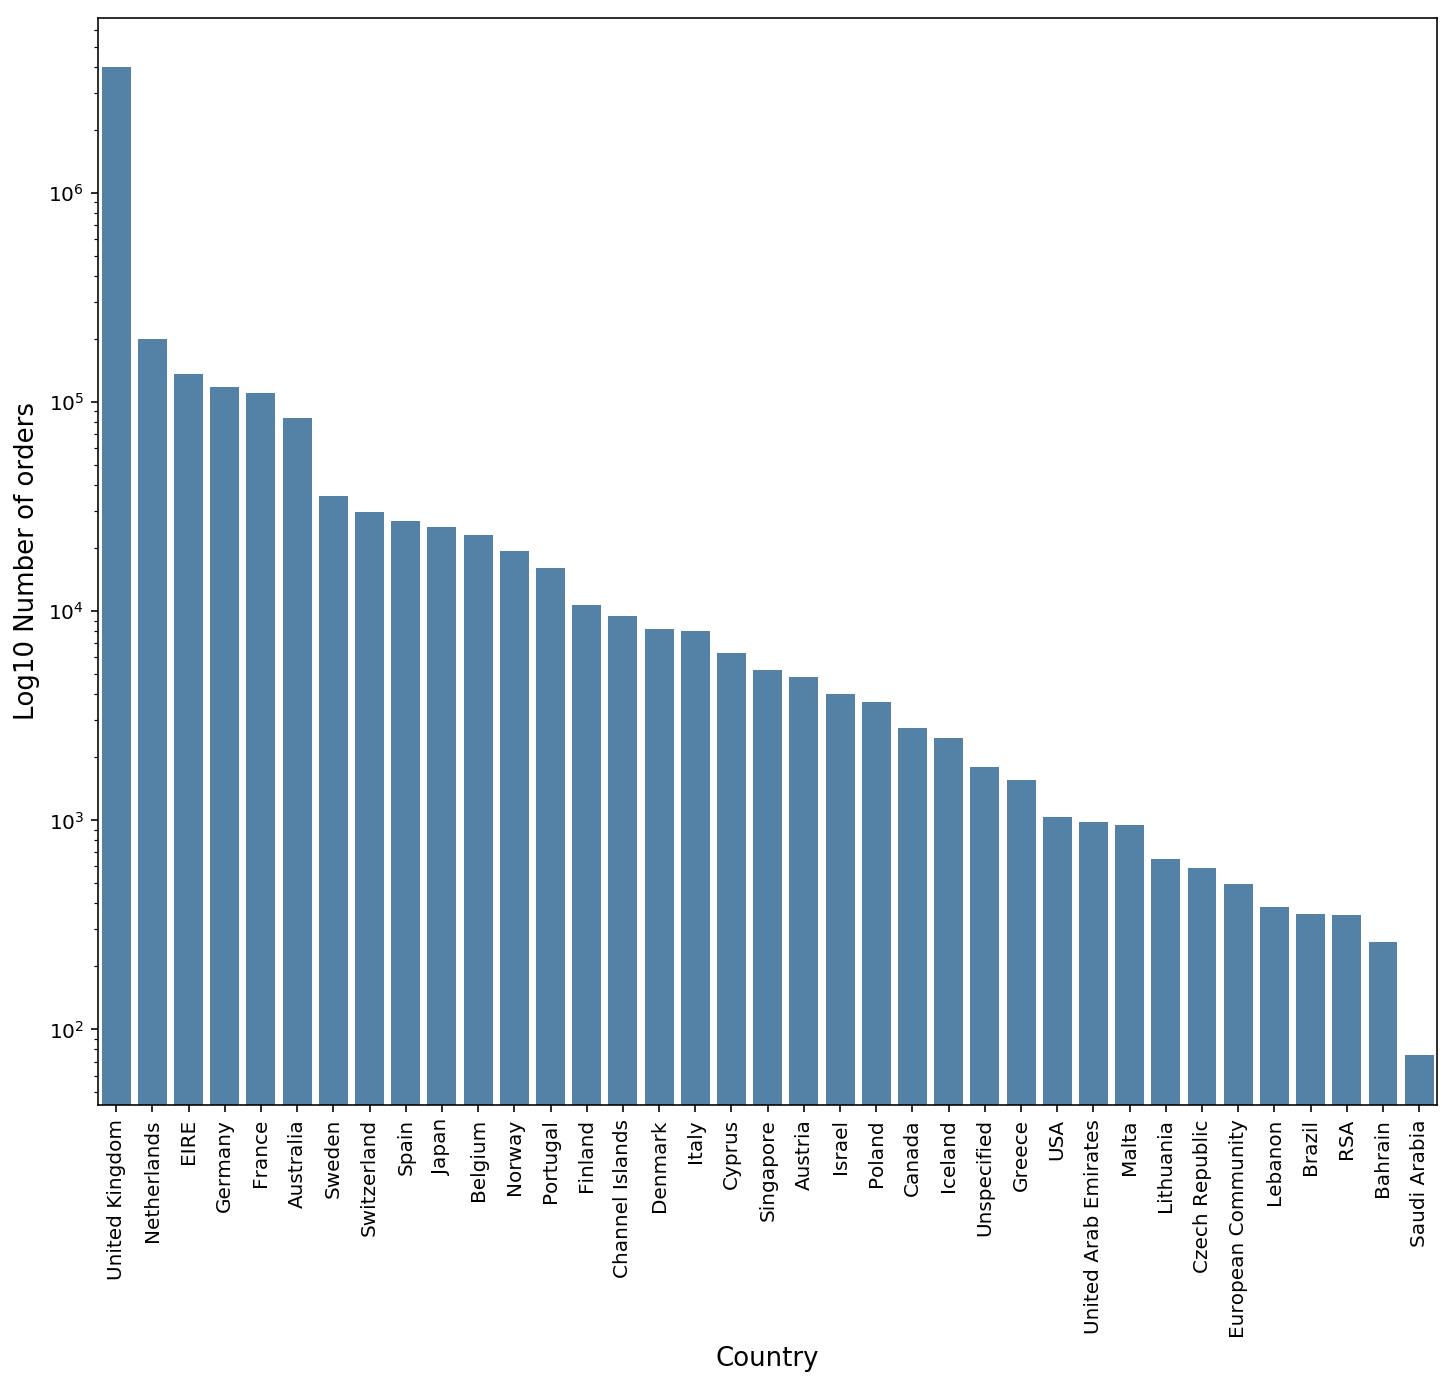

In [21]:
grouped  = data.groupby(['Country']).sum()['Quantity'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values, color='steelblue')
f.get_axes()[0].set_yscale('log') #I'm using a log scale just for visualisation as the UK dominates the market
plt.ylabel('Log10 Number of orders', fontsize=13)
plt.xlabel('Country', fontsize=13)
plt.show()

The United Kingdom purchases the majority of products by almost 2 orders of magnitude.

In [22]:
# group by customer ID and invoice number to create a basket per customer
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
products_per_basket[:10].sort_values('Number of products', ascending=False)

,CustomerID,InvoiceNo,Number of products
7,12347.0,573511,47
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
6,12347.0,562032,22
5,12347.0,556201,18
9,12348.0,539318,17
8,12347.0,581180,11
0,12346.0,541431,1
1,12346.0,C541433,1


There are InvoiceNo entries beginning with the character C.

In [23]:
print('There are:',data['InvoiceNo'].str.contains("C").sum(), 'orders marked C, which contribute',(data['InvoiceNo'].str.contains("C").sum()/len(data))*100, '% of the dataset.')

There are: 8872 orders marked C, which contribute 2.209141343213713 % of the dataset.


In [24]:
# select all the cancelled orders
cancelled_orders = data[data.InvoiceNo.str.contains("C")]
cancelled_orders.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
268308,C560408,M,Manual,-1,7/18/2011 14:24,550.6,13564.0,United Kingdom
186013,C552841,22838,3 TIER CAKE TIN RED AND CREAM,-1,5/11/2011 14:28,14.9,15827.0,United Kingdom
169480,C551175,22325,MOBILE VINTAGE HEARTS,-1,4/26/2011 17:17,5.0,14329.0,United Kingdom
429996,C573575,CRUK,CRUK Commission,-1,10/31/2011 14:09,606.0,14096.0,United Kingdom
281674,C561591,22768,FAMILY PHOTO FRAME CORNICE,-1,7/28/2011 11:17,9.9,15708.0,United Kingdom
268312,C560409,84078A,SET/4 WHITE RETRO STORAGE CUBES,-1,7/18/2011 14:24,40.0,16717.0,United Kingdom
355585,C567947,23234,BISCUIT TIN VINTAGE CHRISTMAS,-1,9/23/2011 8:00,2.9,17663.0,United Kingdom
355584,C567947,21201,TROPICAL HONEYCOMB PAPER GARLAND,-1,9/23/2011 8:00,2.5,17663.0,United Kingdom
96677,C544577,M,Manual,-1,2/21/2011 14:02,320.7,12365.0,Cyprus
45144,C540250,21928,JUMBO BAG SCANDINAVIAN PAISLEY,-1,1/5/2011 16:02,1.6,17511.0,United Kingdom


InvoiceNo containing a "C" character correspond with a negative Quantity value, therefore I will assume these are cancelled orders. For the purposes of this report I am going to remove cancelled orders from consideration.

In [25]:
data = data[~data['InvoiceNo'].str.contains("C")]

In [26]:
# group by customer ID to create a rank buyers by how many products they buy in total.
temp = data.groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].count()
products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
top_baskets = products_per_basket.sort_values('Number of products', ascending=False)
top_baskets.head(10)

,CustomerID,Number of products
4011,17841.0,7676
1880,14911.0,5672
1290,14096.0,5111
326,12748.0,4413
1662,14606.0,2677
2177,15311.0,2366
1690,14646.0,2080
562,13089.0,1814
691,13263.0,1667
1435,14298.0,1637


/Users/scheckley/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


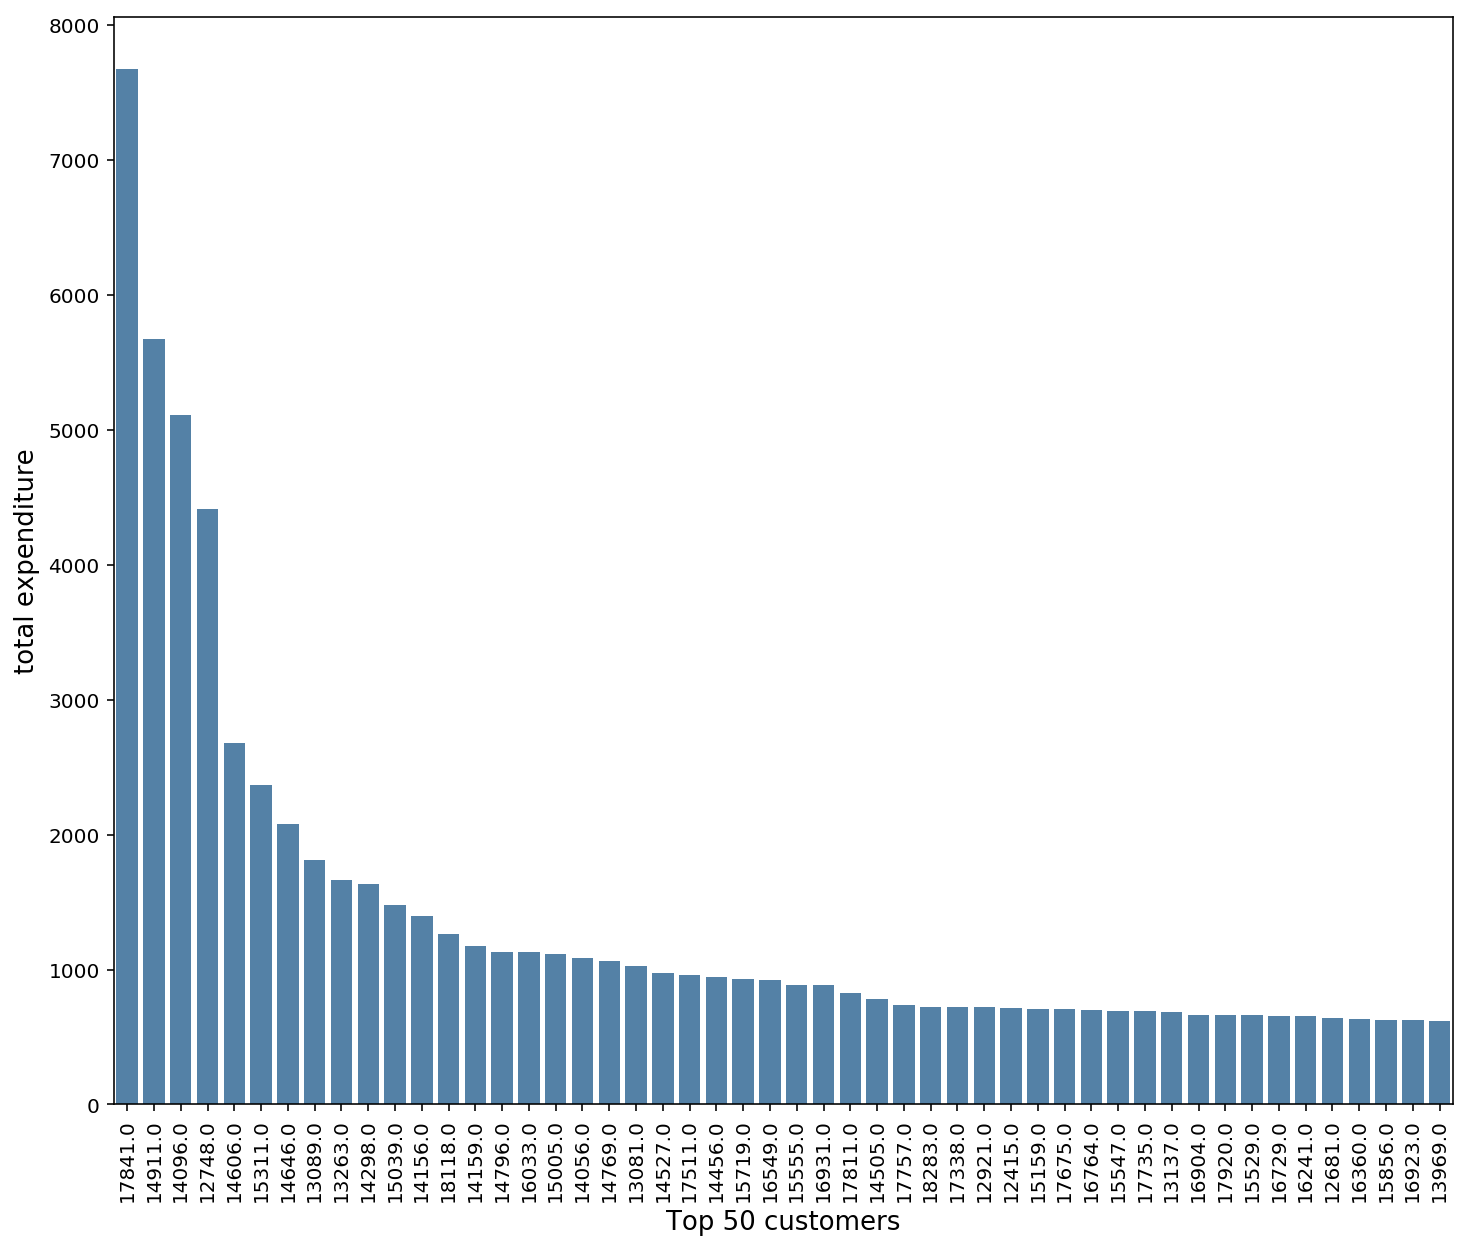

In [27]:
grouped = top_baskets[:50]
grouped.reset_index(level=0, inplace=True)
grouped.sort_values('Number of products', ascending=False, inplace=True)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(x=grouped['CustomerID'], y=grouped['Number of products'],order=grouped['CustomerID'],color='steelblue',ci=None)
plt.ylabel('total expenditure', fontsize=13)
plt.xlabel('Top 50 customers', fontsize=13)
plt.show()

Investigation of which items are contained in the top CustomerID basket

In [28]:
top_basket = data[data['CustomerID'] == top_baskets['CustomerID'].iloc[0]]
top_basket

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
451888,575298,20668,DISCO BALL CHRISTMAS DECORATION,288,11/9/2011 12:29,0.1,17841.0,United Kingdom
277498,561113,16045,POPART WOODEN PENCILS ASST,200,7/25/2011 12:09,0.0,17841.0,United Kingdom
315623,564733,20668,DISCO BALL CHRISTMAS DECORATION,144,8/28/2011 13:18,0.1,17841.0,United Kingdom
499593,578678,22161,HEART DECORATION RUSTIC HANGING,128,11/24/2011 19:59,0.2,17841.0,United Kingdom
221431,556245,22467,GUMBALL COAT RACK,108,6/9/2011 16:10,2.1,17841.0,United Kingdom
388233,570420,20668,DISCO BALL CHRISTMAS DECORATION,96,10/10/2011 13:33,0.1,17841.0,United Kingdom
407073,571846,20668,DISCO BALL CHRISTMAS DECORATION,72,10/19/2011 12:35,0.1,17841.0,United Kingdom
428730,573496,20668,DISCO BALL CHRISTMAS DECORATION,72,10/31/2011 11:59,0.1,17841.0,United Kingdom
360442,568227,84341B,SMALL PINK MAGIC CHRISTMAS TREE,72,9/26/2011 10:57,0.4,17841.0,United Kingdom
448683,575070,20668,DISCO BALL CHRISTMAS DECORATION,72,11/8/2011 12:58,0.1,17841.0,United Kingdom


### Investigation of StockCode

There are some non-integer values in StockCodes which correspond with order descriptions that are not items.

In [29]:
mask = (~data['StockCode'].str.contains('[0-9]'))
odd_stock_codes = data.loc[mask] #filter out any stock codes that are numeric to leave the non-standard codes
odd_stock_codes.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
490502,578060,M,Manual,1600,11/22/2011 15:22,0.2,17857.0,United Kingdom
452218,575328,M,Manual,1200,11/9/2011 13:48,0.2,17857.0,United Kingdom
437235,574277,M,Manual,832,11/3/2011 14:42,0.2,17857.0,United Kingdom
526018,580646,M,Manual,800,12/5/2011 13:13,0.2,17857.0,United Kingdom
414138,572344,M,Manual,456,10/24/2011 10:43,1.5,14607.0,United Kingdom


In [30]:
odd_stock_codes['StockCode'].unique(), print('total number of these short stock code entries:',len(odd_stock_codes))

total number of these short stock code entries: 1416


(array(['M', 'POST', 'DOT', 'BANK CHARGES', 'PADS'], dtype=object), None)

As the number of non-standard stock codes is small, for the purposes of this report they will be deleted from the dataset.

In [31]:
data = data.loc[~mask]

During the data cleaning process NaN, duplicate entries, cancelled invoices, and miscellaneous stock codes have been removed.

## Investigation of Invoice Date

In [32]:
timestamp_list = list(data.InvoiceDate)

Timeframe = pd.DataFrame(pd.to_datetime(timestamp_list), columns=['time'])

In [33]:
data['time'] = Timeframe['time'].values

In [34]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,time
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.1,16446.0,United Kingdom,2011-12-09 09:15:00
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.0,12346.0,United Kingdom,2011-01-18 10:01:00
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.0,13256.0,United Kingdom,2011-11-25 15:57:00
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.2,12901.0,United Kingdom,2011-10-27 12:26:00
206121,554868,22197,SMALL POPCORN HOLDER,4300,5/27/2011 10:52,0.7,13135.0,United Kingdom,2011-05-27 10:52:00


/Users/scheckley/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  This is separate from the ipykernel package so we can avoid doing imports until


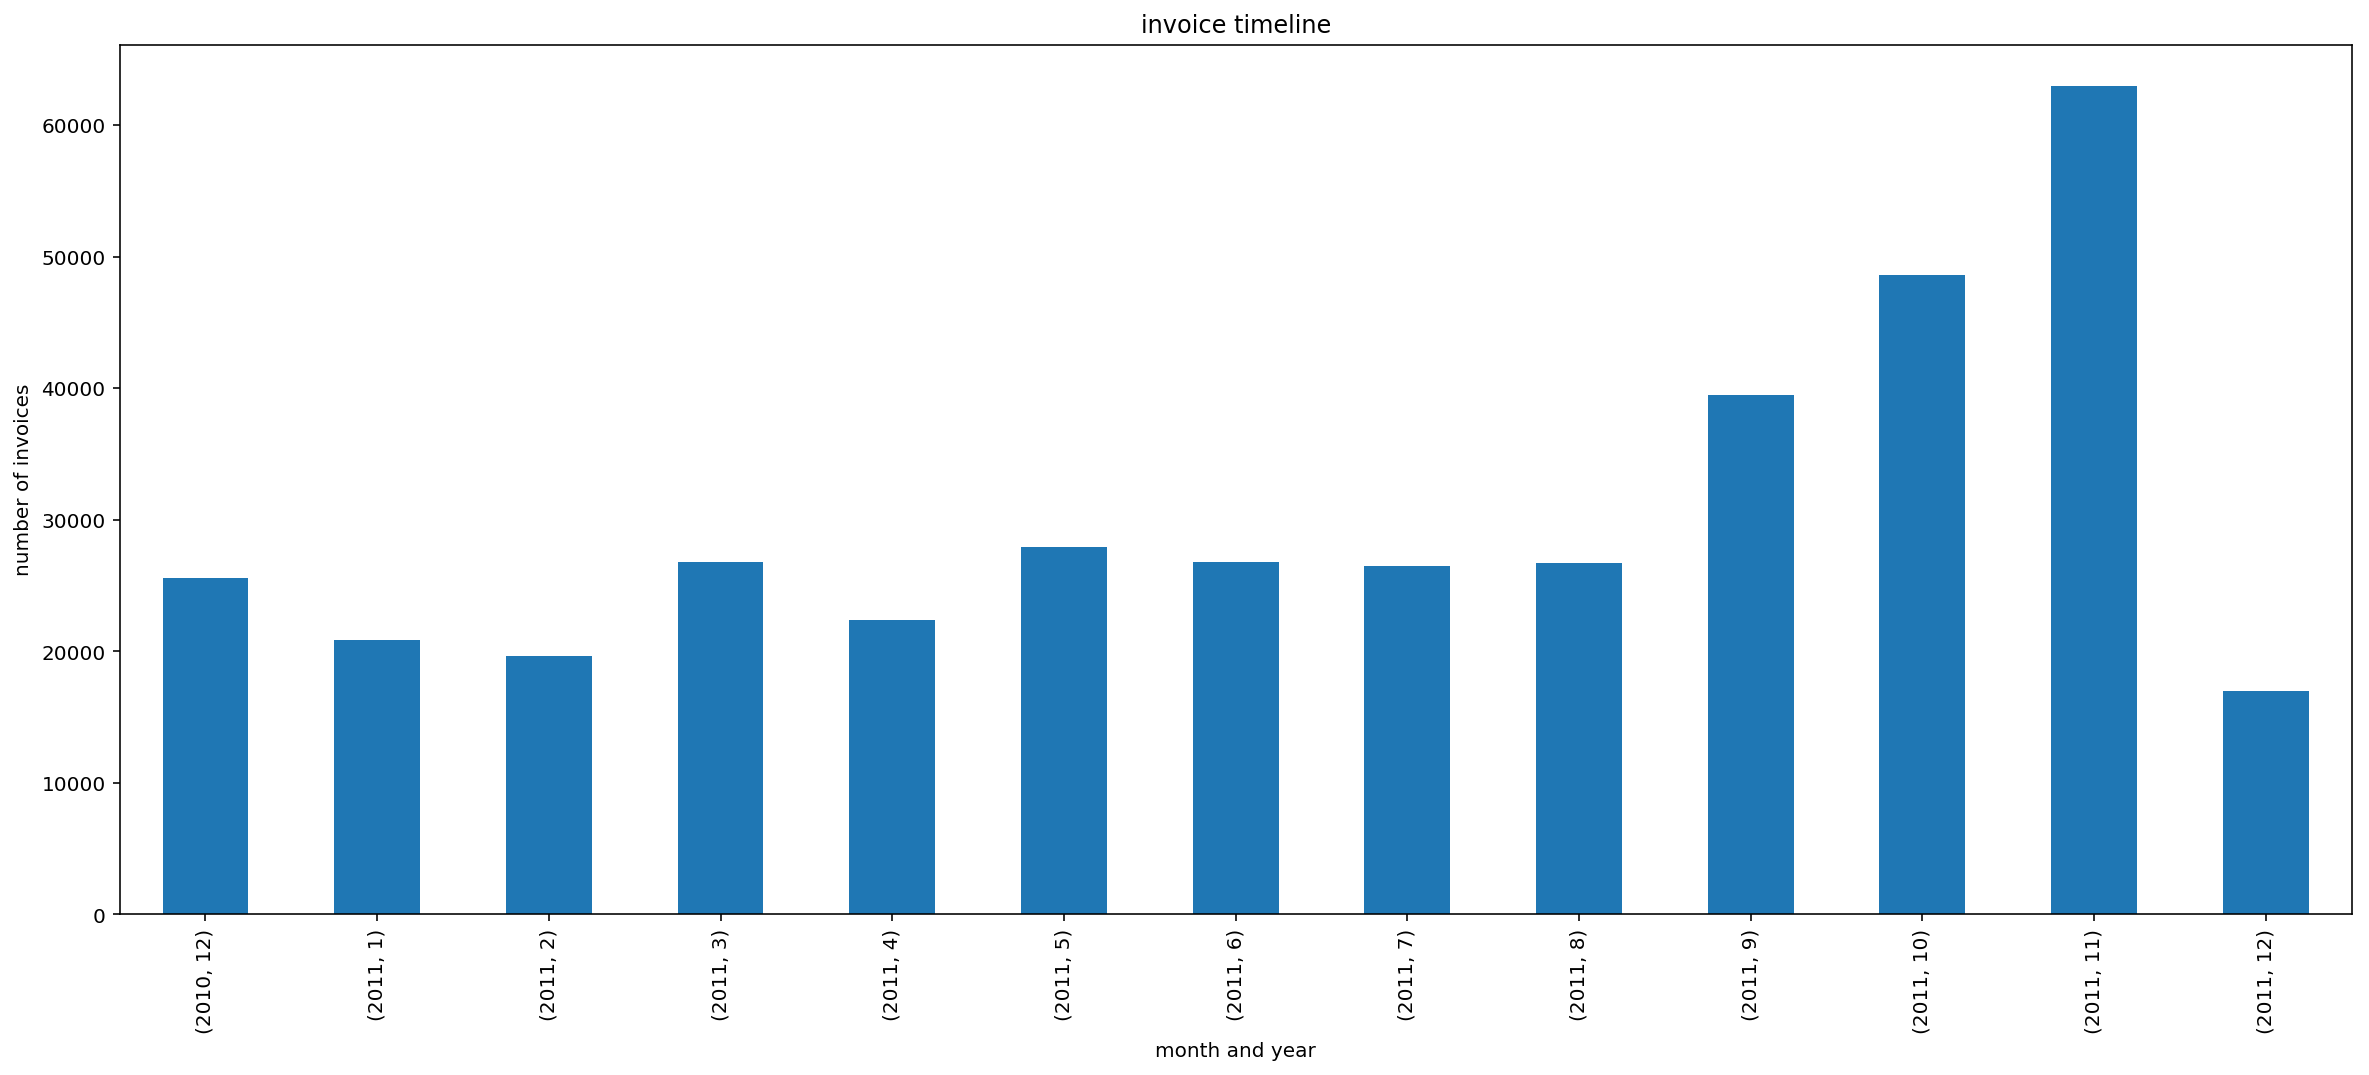

In [35]:
plot_dims = (20, 8)

plot = Timeframe.groupby((Timeframe['time'].dt.year, Timeframe['time'].dt.month.rename('month'))).count().plot(kind="bar",figsize=plot_dims,legend=False)

plot.set(xlabel='month and year', ylabel='number of invoices',title="invoice timeline")
plt.xticks(rotation=90)
plt.show()

Invoice numbers increase in September and October and peak in November, possibly attributed to Christmas shopping?

## Feature engineering

In [36]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,time
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.1,16446.0,United Kingdom,2011-12-09 09:15:00
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.0,12346.0,United Kingdom,2011-01-18 10:01:00
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.0,13256.0,United Kingdom,2011-11-25 15:57:00
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.2,12901.0,United Kingdom,2011-10-27 12:26:00
206121,554868,22197,SMALL POPCORN HOLDER,4300,5/27/2011 10:52,0.7,13135.0,United Kingdom,2011-05-27 10:52:00


In [37]:
total_spend = data['Quantity'] * data['UnitPrice']

In [38]:
data = data.assign(total_spend=total_spend.values)

In [39]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,time,total_spend
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.1,16446.0,United Kingdom,2011-12-09 09:15:00,168469.6
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.0,12346.0,United Kingdom,2011-01-18 10:01:00,77183.6
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.0,13256.0,United Kingdom,2011-11-25 15:57:00,0.0
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.2,12901.0,United Kingdom,2011-10-27 12:26:00,1008.0
206121,554868,22197,SMALL POPCORN HOLDER,4300,5/27/2011 10:52,0.7,13135.0,United Kingdom,2011-05-27 10:52:00,3096.0


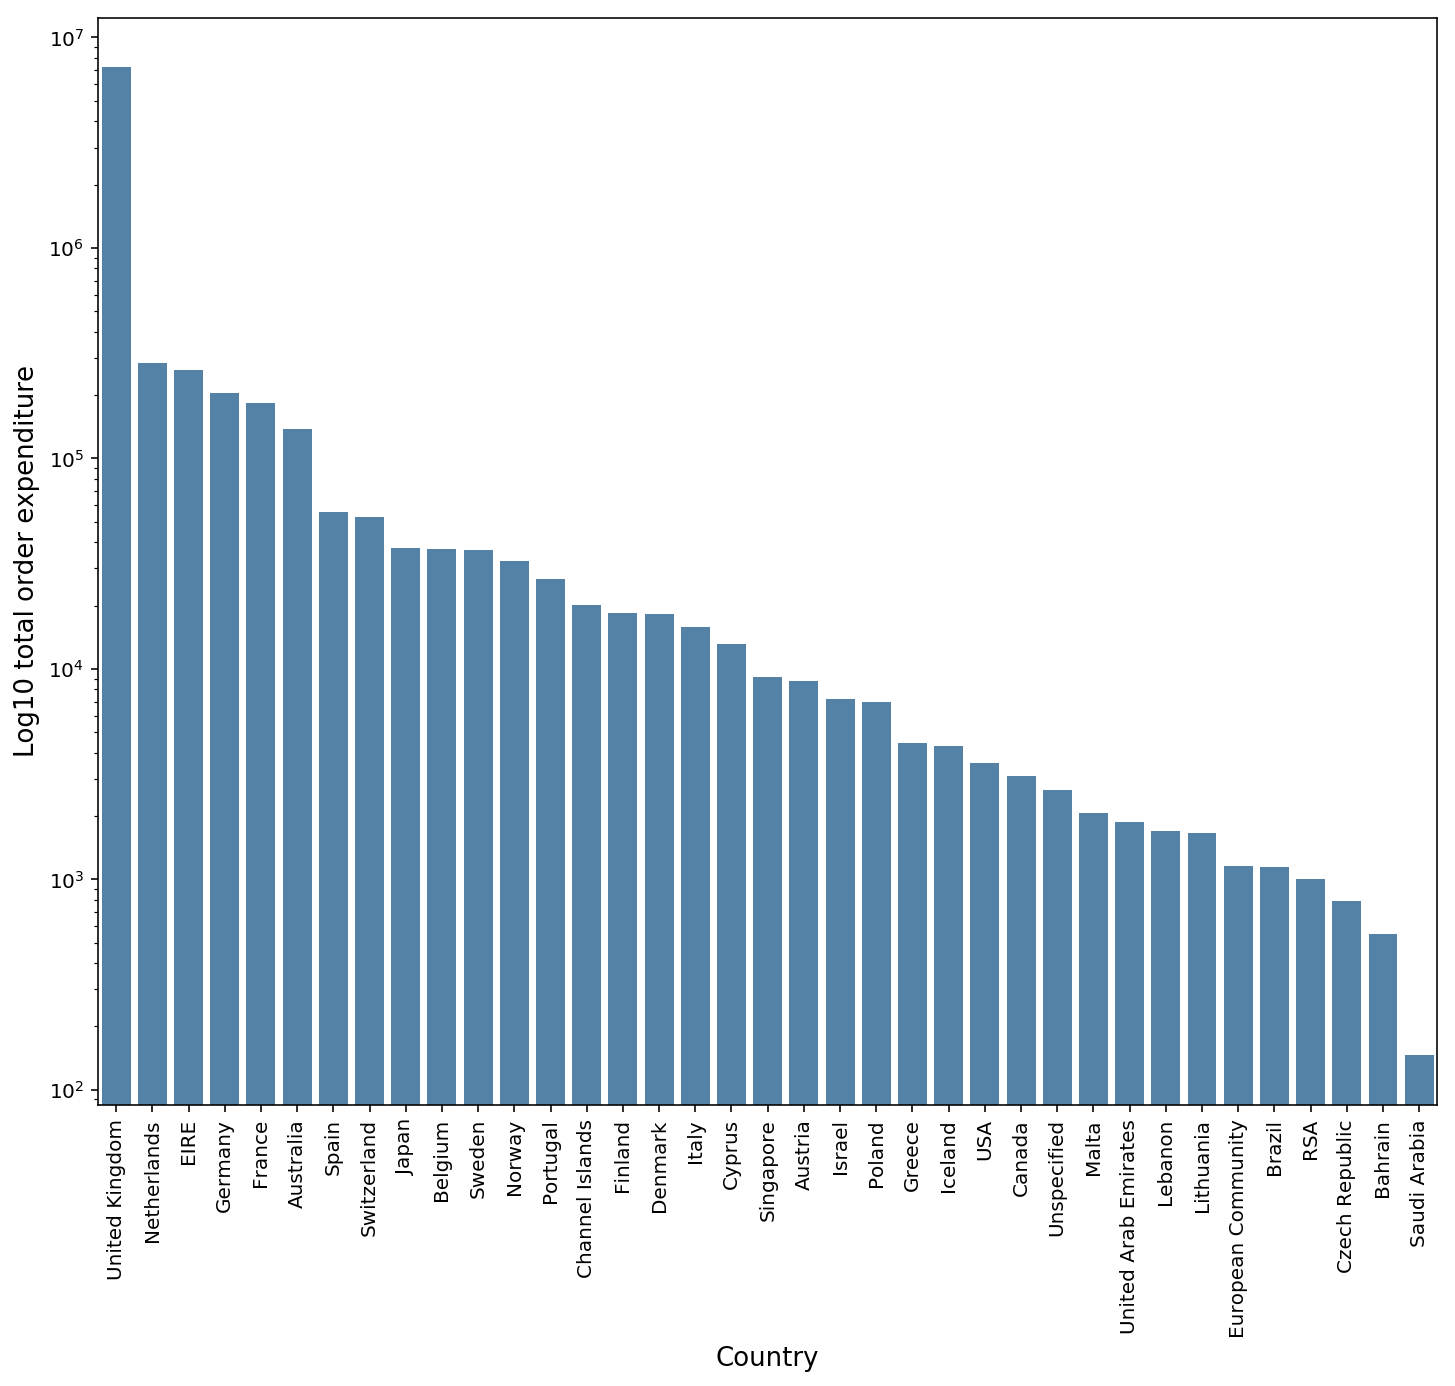

In [40]:
grouped  = data.groupby(['Country']).sum()['total_spend'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values, color='steelblue')
f.get_axes()[0].set_yscale('log') #I'm using a log scale just for visualisation as the UK dominates the market
plt.ylabel('Log10 total order expenditure', fontsize=13)
plt.xlabel('Country', fontsize=13)
plt.show()

Customers from the United Kingdom spend the most money in addition to placing the most orders.

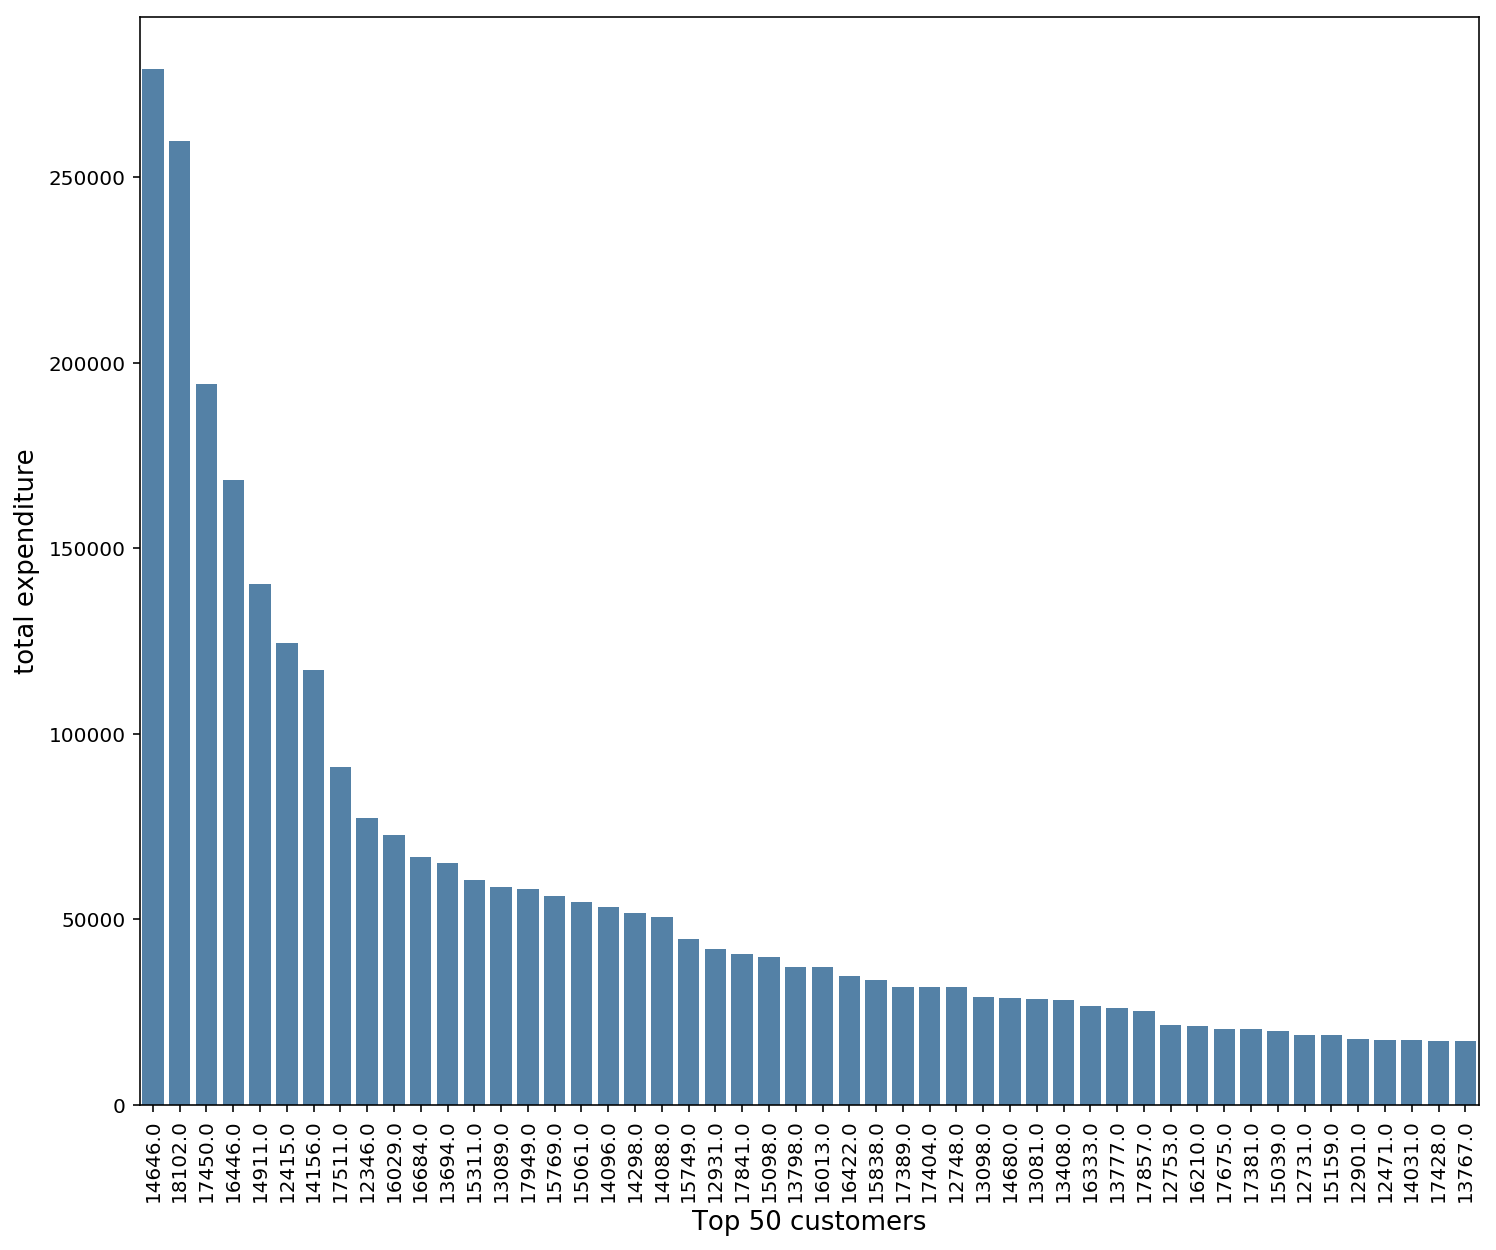

In [41]:
grouped  = data.groupby(['CustomerID']).sum()['total_spend'].sort_values(ascending=False)
grouped_top = pd.DataFrame(grouped.head(50))
grouped_top.reset_index(level=0, inplace=True)
grouped_top.sort_values('CustomerID', ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(x=grouped_top['CustomerID'], y=grouped_top['total_spend'],order=grouped_top['CustomerID'],color='steelblue')
plt.ylabel('total expenditure', fontsize=13)
plt.xlabel('Top 50 customers', fontsize=13)
plt.show()

Calculate the top 50 largest baskets, in terms of total spend

In [42]:
top_50 = data[data['CustomerID'].isin(grouped_top['CustomerID'])]
top_50.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,time,total_spend
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.1,16446.0,United Kingdom,2011-12-09 09:15:00,168469.6
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.0,12346.0,United Kingdom,2011-01-18 10:01:00,77183.6
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.2,12901.0,United Kingdom,2011-10-27 12:26:00,1008.0
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,4/18/2011 13:20,2.1,15749.0,United Kingdom,2011-04-18 13:20:00,6539.4
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,1/11/2011 12:55,2.1,15749.0,United Kingdom,2011-01-11 12:55:00,6539.4


Locate the country of origin of the top 50 biggest spenders

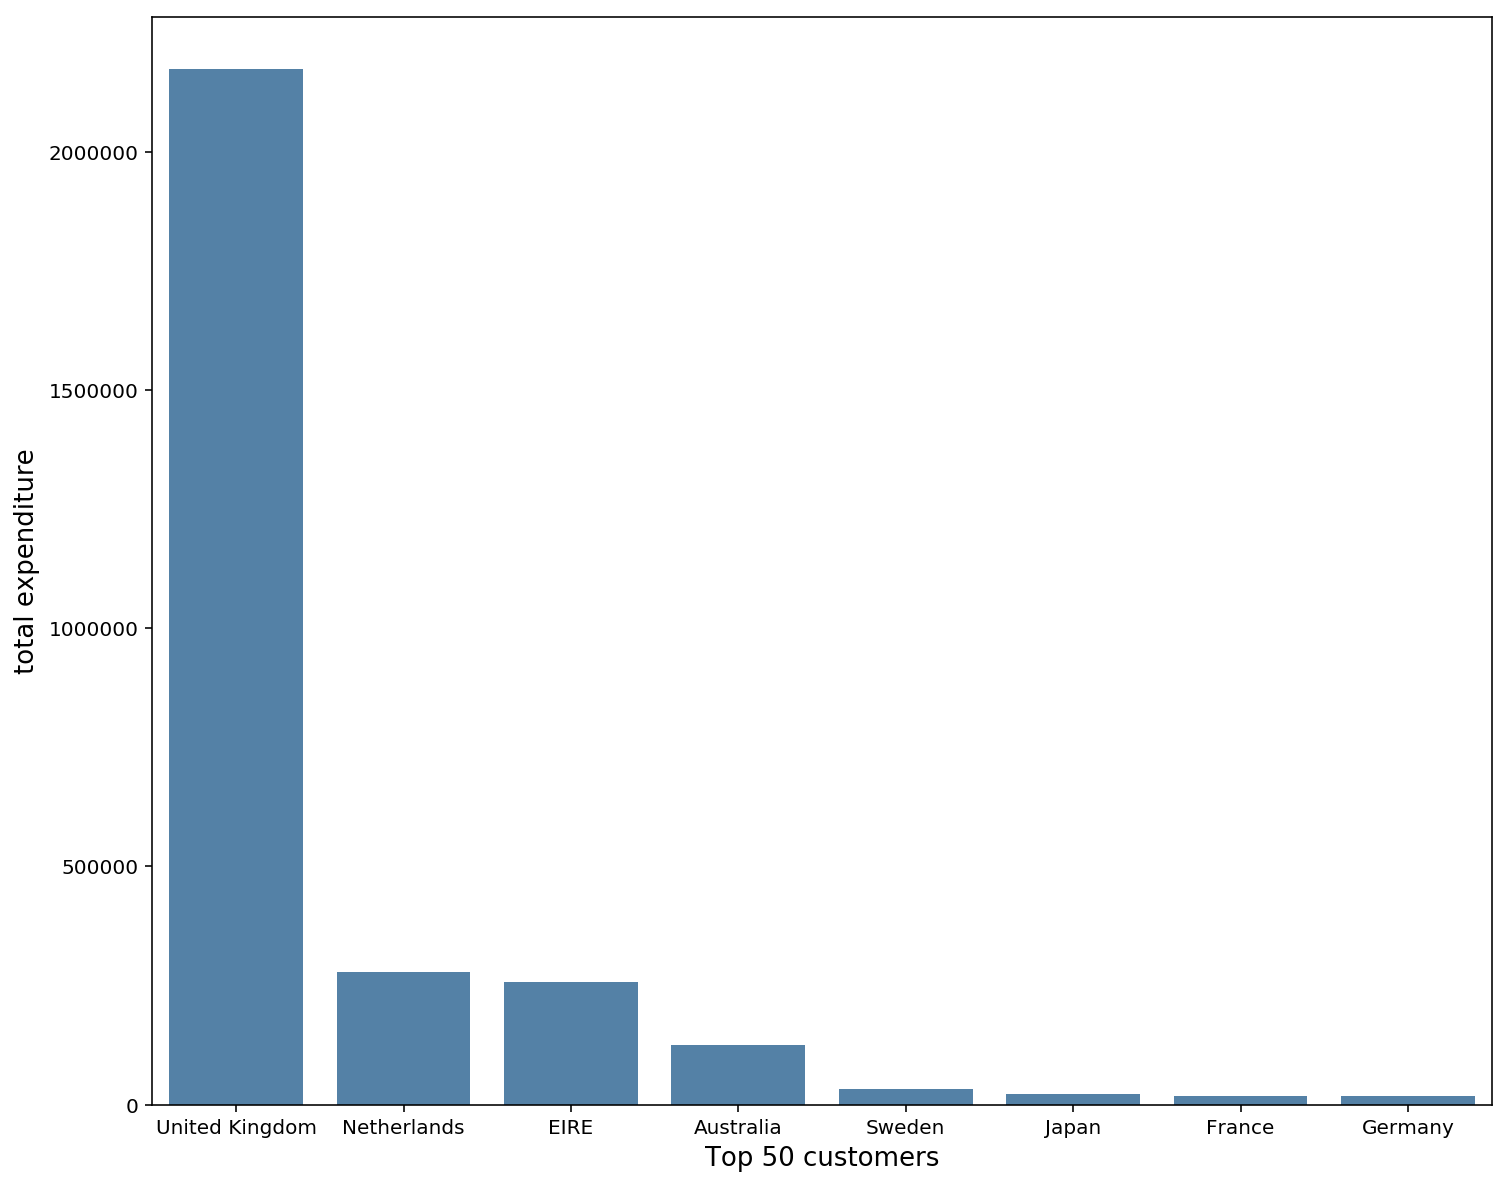

In [43]:
top50_tmp  = top_50.groupby(['Country']).sum()['total_spend'].sort_values(ascending=False)

top50_tmp = pd.DataFrame(top50_tmp)
top50_tmp.reset_index(level=0, inplace=True)
top50_tmp.sort_values('Country', ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='horizontal')
sns.barplot(x=top50_tmp['Country'], y=top50_tmp['total_spend'],order=top50_tmp['Country'],color='steelblue')
plt.ylabel('total expenditure', fontsize=13)
plt.xlabel('Top 50 customers', fontsize=13)
plt.show()

## Label customer using spend

Collate all the purchases made during a single order to calculate the total order value:

In [44]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['total_spend'].sum()
basket_price = temp.rename(columns = {'total_spend':'Basket value'})

In [45]:
# top 10 baskets
basket_price.head(10)

,CustomerID,InvoiceNo,Basket value
0,12346.0,541431,77183.6
1,12347.0,537626,711.8
2,12347.0,542237,475.4
3,12347.0,549222,636.2
4,12347.0,556201,382.5
5,12347.0,562032,584.9
6,12347.0,573511,1294.3
7,12347.0,581180,224.8
8,12348.0,539318,652.8
9,12348.0,541998,187.4


/Users/scheckley/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


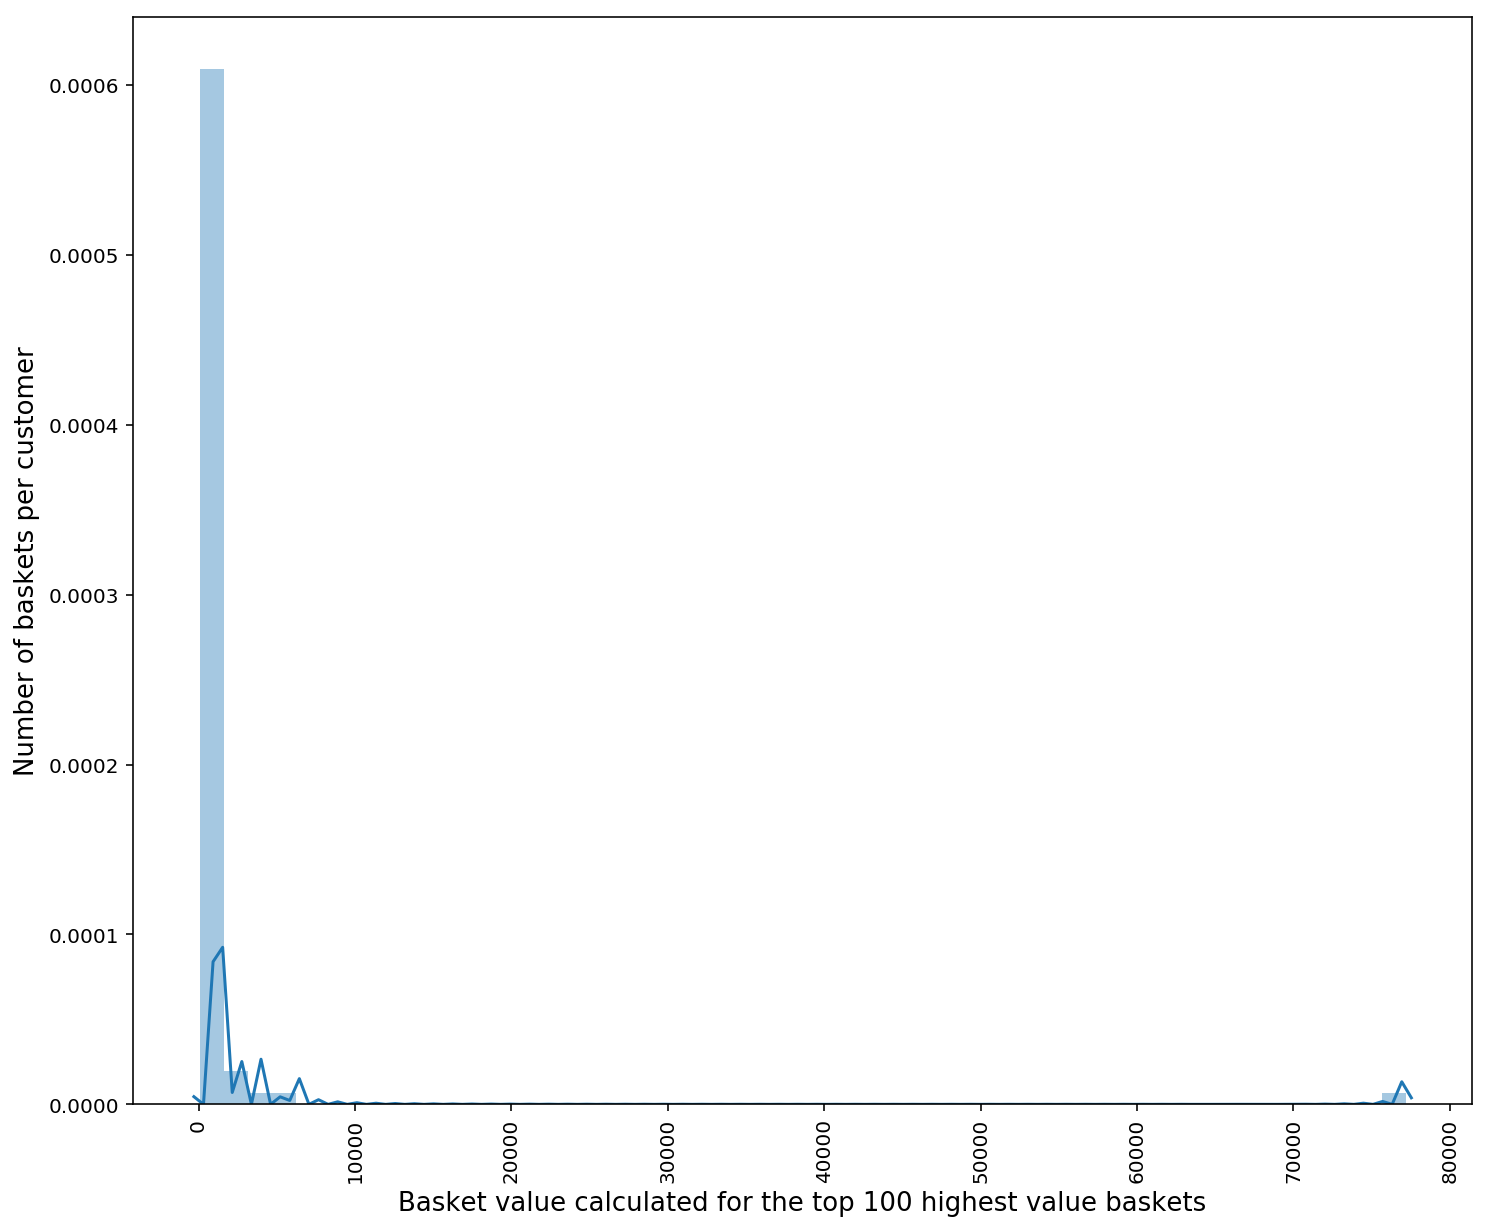

In [46]:
tmp = basket_price
tmp = pd.DataFrame(tmp)
#tmp.reset_index(level=0, inplace=True)
tmp.sort_values('Basket value', ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.distplot(tmp['Basket value'][:100])
plt.ylabel('Number of baskets per customer', fontsize=13)
plt.xlabel('Basket value calculated for the top 100 highest value baskets', fontsize=13)
plt.show()

The distribution of basket is somewhat bimodal.  This histogram of basket values indicates a large number of low total value baskets and a small number of individual orders totaling high value baskets. This observation can be used to bin customers into those spending small amounts, medium amounts, and high value baskets:

In [47]:
med_spend = 10000
big_spend = 50000

In [48]:
spend_label = []
for i in range(0,len(data),1):
    if data['total_spend'].iloc[i] < 10000:
        spend_label.append('small_spend')
    elif data['total_spend'].iloc[i] >50000:
        spend_label.append('big_spend')
    else:
        spend_label.append('med_spend')

In [49]:
data['spend_label'] = spend_label

In [50]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,time,total_spend,spend_label
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.1,16446.0,United Kingdom,2011-12-09 09:15:00,168469.6,big_spend
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.0,12346.0,United Kingdom,2011-01-18 10:01:00,77183.6,big_spend
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.0,13256.0,United Kingdom,2011-11-25 15:57:00,0.0,small_spend
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.2,12901.0,United Kingdom,2011-10-27 12:26:00,1008.0,small_spend
206121,554868,22197,SMALL POPCORN HOLDER,4300,5/27/2011 10:52,0.7,13135.0,United Kingdom,2011-05-27 10:52:00,3096.0,small_spend


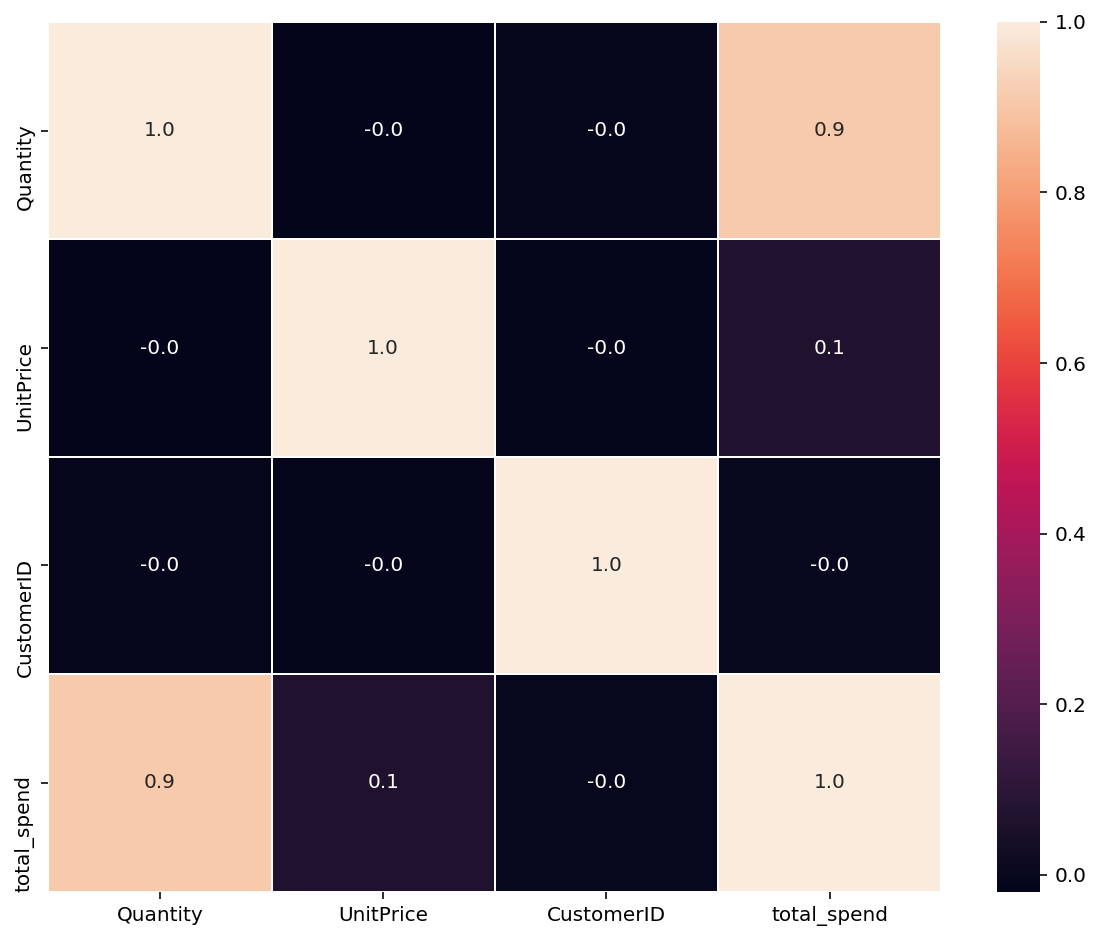

In [51]:
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);

High correlation between total_spend and quantity (unsurprisingly)

In [ ]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(Xdata[:1000])
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

In [97]:
pca = decomposition.PCA(n_components=11)
pc = pca.fit_transform(Xdata)

pc_df = pd.DataFrame(data = pc , 
        columns = ['PC1', 'PC2','PC3','PC4', 'PC5','PC6','PC7','PC8','PC9','PC10','PC11'])
pc_df['Cluster'] = ydata
pc_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,Cluster
0,-20877.8,-993.4,186557.9,-11377.6,-262.0,2.0,0.0,-0.1,0.6,0.6,0.4,small_spend
1,19169.2,3045.2,103536.4,27185.3,307.1,1.8,0.2,-0.5,0.7,0.8,0.6,small_spend
2,-18247.5,2049.3,6085.0,10947.8,142.2,0.5,0.1,-0.1,0.2,0.2,0.1,small_spend
3,-12414.7,2398.9,3192.3,3698.5,45.7,0.4,0.0,-0.0,0.1,0.1,0.0,small_spend
4,5725.4,2164.2,4770.9,2244.4,25.4,0.4,0.0,-0.0,0.1,0.0,0.0,small_spend


In [98]:
pca.explained_variance_ratio_

array([9.82478902e-01, 1.67769024e-02, 7.19302487e-04, 2.47866530e-05,
       1.04894888e-07, 5.13054232e-10, 1.22543039e-10, 1.08226720e-10,
       6.03660983e-11, 3.47309646e-11, 3.08944229e-11])

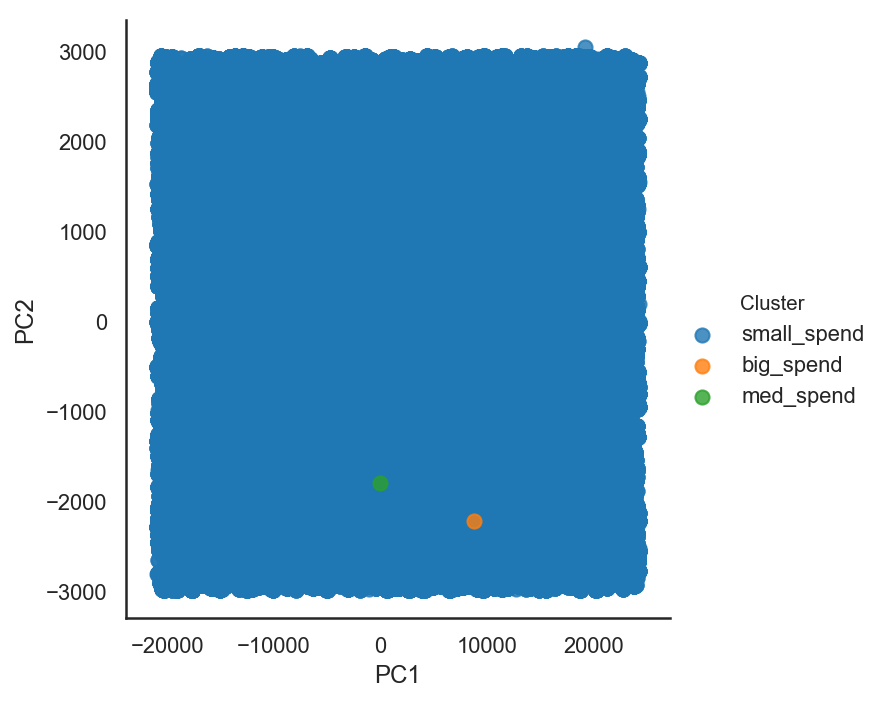

In [99]:
#plot the clusters
sns.lmplot( x="PC1", y="PC2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 50}); # specify the point size

## Clustering

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

/Users/scheckley/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [53]:
# encode the spend_label
cols_to_transform = ['Country']
type_hash = pd.get_dummies(data=data['Country'])

#cols_to_transform = ['spend_label']
#type_hash2 = pd.get_dummies(data=data['spend_label'])

In [54]:
data = pd.concat([data, type_hash], axis=1)

In [55]:
cluster_data = data.copy()
Xdata = data.copy()
ydata = data['spend_label']

In [56]:
Xdata.drop(['Description', 'InvoiceDate','Country','time','spend_label','StockCode'], axis=1, inplace=True)
Xdata['InvoiceNo'] = pd.to_numeric(Xdata['InvoiceNo'], errors='coerce')

In [57]:
Xdata.head()

,InvoiceNo,Quantity,UnitPrice,CustomerID,total_spend,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,EIRE,European Community,Finland,France,Germany,Greece,Iceland,Israel,Italy,Japan,Lebanon,Lithuania,Malta,Netherlands,Norway,Poland,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
540421,581483,80995,2.1,16446.0,168469.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
61619,541431,74215,1.0,12346.0,77183.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
502122,578841,12540,0.0,13256.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
421632,573008,4800,0.2,12901.0,1008.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
206121,554868,4300,0.7,13135.0,3096.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [79]:
#http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100, n_jobs=-1)
kmeans.fit(Xdata[:1000])
clusters_clients = kmeans.predict(Xdata[:1000])
silhouette_avg = silhouette_score(Xdata[:1000], clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.384


In [80]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['number of customers']).T

,0,3,7,6,4,1,10,9,8,5,2
number of customers,158,143,141,132,106,97,88,67,66,1,1


In [81]:
from sklearn.decomposition import PCA

In [87]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(Xdata[:1000])
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

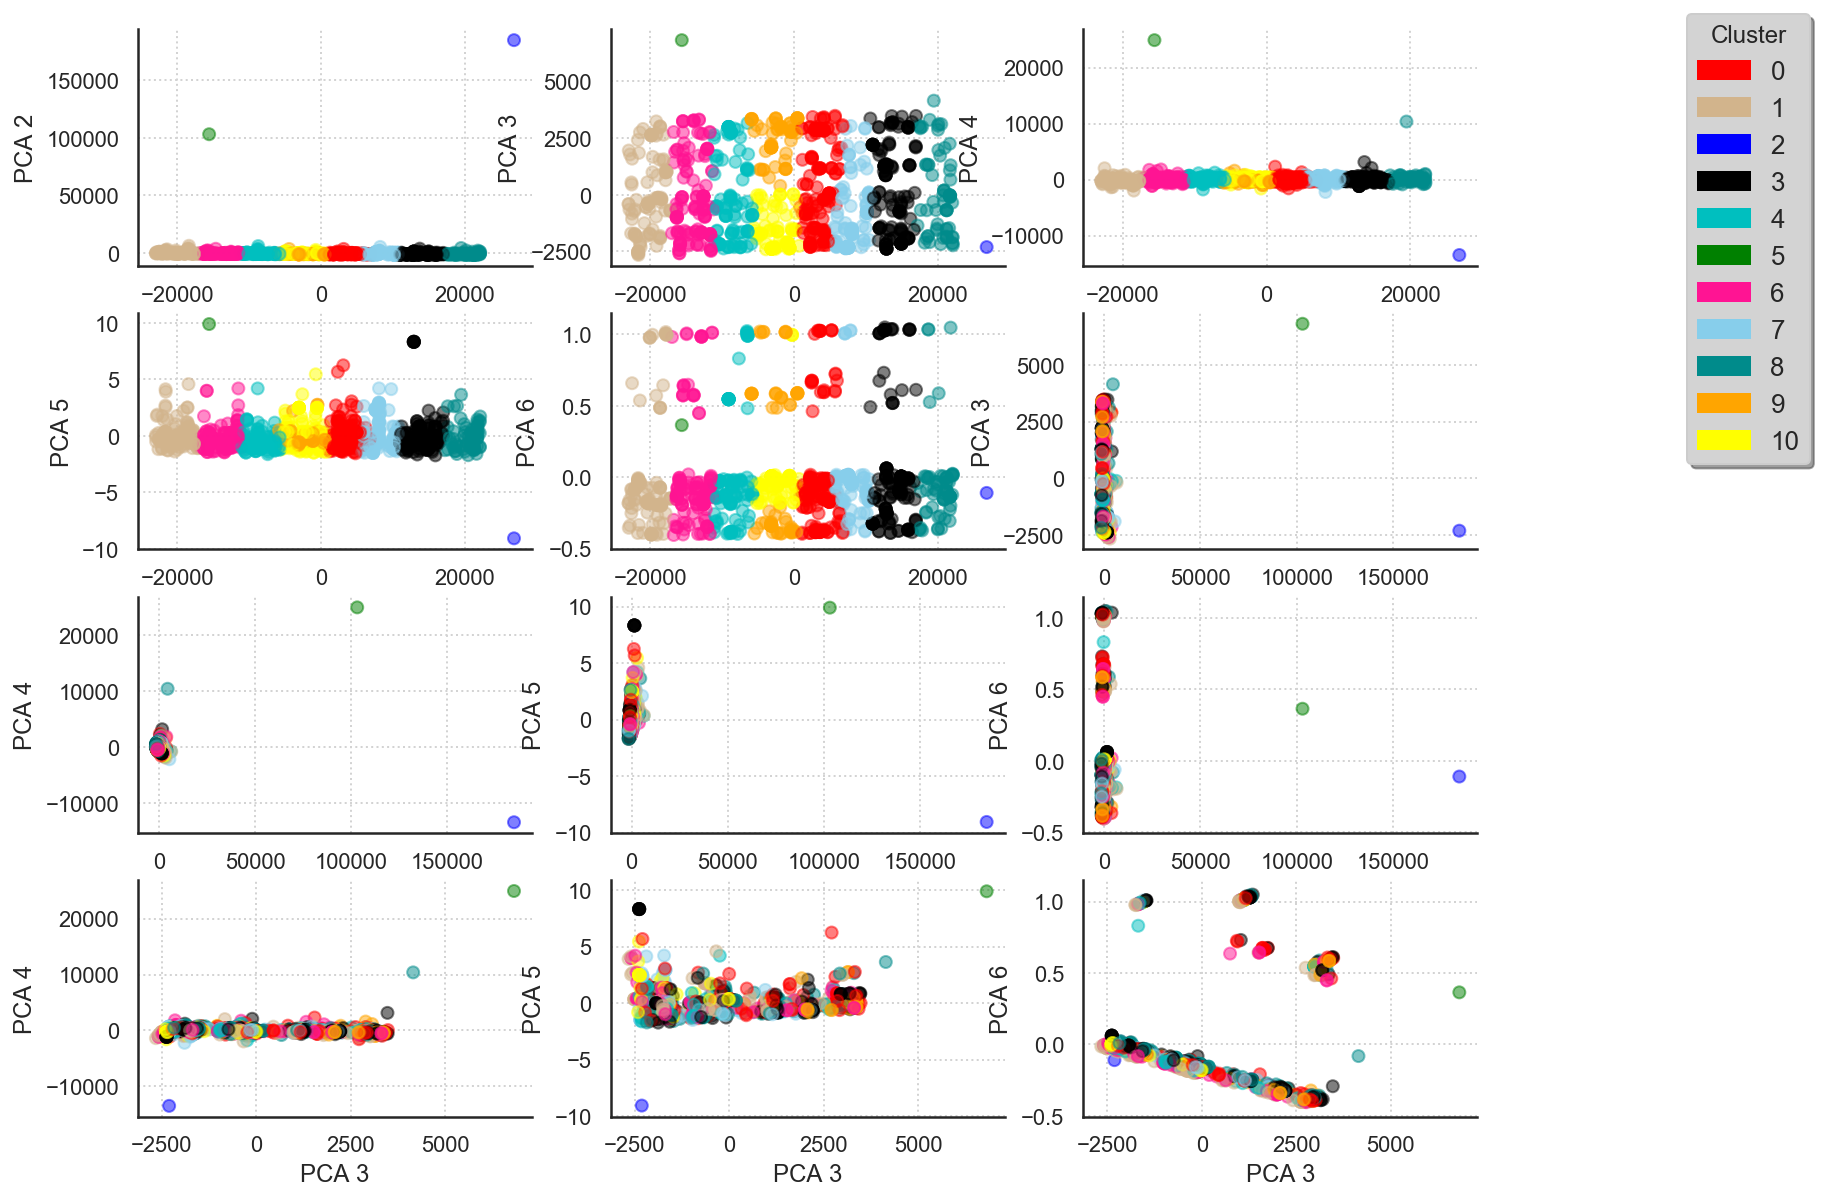

In [88]:
import matplotlib.patches as mpatches

#sns.set_style("white")
#sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        

comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)


## Todo

* vectorize the descriptions, and any other strings as you've done with country
* scale the quantity and price columns (only the numerical quantity columns, basically)


## Addendum - Apriori modeling example

Apriori modeling requires no feature engineering, machine learning, or significant compute time and is an alternative approach to machine learning for this form of exercise.

Modeling will be applied to the top customer identified in section *** as a proof of concept recommender system.

### Generate a basket for each country

In [59]:
#basket = (data[data['Country'] == "Netherlands"]
#          .groupby(['InvoiceNo', 'Description'])['Quantity']
#          .sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))

basket = top_basket.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

In [60]:
basket.head()

Description,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PINK HEN+CHICKS IN BASKET,12 RED ROSE PEG PLACE SETTINGS,16 PIECE CUTLERY SET PANTRY DESIGN,2 PICTURE BOOK EGGS EASTER BUNNY,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 PINK HEN+CHICKS IN BASKET,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TRADITIONAl BISCUIT CUTTERS SET,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,3D CHRISTMAS STAMPS STICKERS,4 BLUE DINNER CANDLES SILVER FLOCK,4 BURGUNDY WINE DINNER CANDLES,4 IVORY DINNER CANDLES SILVER FLOCK,4 PINK DINNER CANDLE SILVER FLOCK,4 PINK FLOCK CHRISTMAS BALLS,4 PURPLE FLOCK DINNER CANDLES,4 SKY BLUE DINNER CANDLES,5 HOOK HANGER RED MAGIC TOADSTOOL,50CM METAL STRING WITH 7 CLIPS,6 CHOCOLATE LOVE HEART T-LIGHTS,6 EGG HOUSE PAINTED WOOD,6 RIBBONS RUSTIC CHARM,6 RIBBONS SHIMMERING PINKS,6 ROCKET BALLOONS,60 TEATIME FAIRY CAKE CASES,72 SWEETHEART FAIRY CAKE CASES,75 GREEN FAIRY CAKE CASES,ABC TREASURE BOOK BOX,"ACRYLIC JEWEL ICICLE, BLUE","ACRYLIC JEWEL SNOWFLAKE, PINK",ADULT APRON APPLE DELIGHT,...,WOOD STAMP SET BEST WISHES,WOOD STAMP SET FLOWERS,WOOD STAMP SET HAPPY BIRTHDAY,WOOD STAMP SET THANK YOU,WOOD STOCKING CHRISTMAS SCANDISPOT,WOODEN ADVENT CALENDAR CREAM,WOODEN ADVENT CALENDAR RED,WOODEN BOX OF DOMINOES,WOODEN FRAME ANTIQUE WHITE,WOODEN HAPPY BIRTHDAY GARLAND,WOODEN HEART CHRISTMAS SCANDINAVIAN,WOODEN PICTURE FRAME WHITE FINISH,WOODEN REGATTA BUNTING,WOODEN SCHOOL COLOURING SET,WOODEN STAR CHRISTMAS SCANDINAVIAN,WOODEN TREE CHRISTMAS SCANDINAVIAN,WOODEN UNION JACK BUNTING,WOODLAND CHARLOTTE BAG,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND MINI BACKPACK,WOVEN ROSE GARDEN CUSHION COVER,WOVEN SUNSET CUSHION COVER,WRAP 50'S CHRISTMAS,WRAP ALPHABET DESIGN,WRAP CHRISTMAS VILLAGE,WRAP COWBOYS,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP MAGIC FOREST,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,YELLOW EASTER EGG HUNT START POST,ZINC HEART T-LIGHT HOLDER,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [61]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

In [62]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [63]:
frequent_itemsets = apriori(basket_sets, min_support=0.2, use_colnames=True) #70% support required for an association

In [64]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(CHILLI LIGHTS),(BLUE/CREAM STRIPE CUSHION COVER),0.5,0.4,0.2,0.4,1.0,0.0,1.0
1,(BLUE/CREAM STRIPE CUSHION COVER),(CHILLI LIGHTS),0.4,0.5,0.2,0.5,1.0,0.0,1.0
2,(GUMBALL COAT RACK),(BLUE/CREAM STRIPE CUSHION COVER),0.4,0.4,0.2,0.6,1.5,0.1,1.4
3,(BLUE/CREAM STRIPE CUSHION COVER),(GUMBALL COAT RACK),0.4,0.4,0.2,0.5,1.5,0.1,1.4
4,(PACK OF 60 DINOSAUR CAKE CASES),(BLUE/CREAM STRIPE CUSHION COVER),0.4,0.4,0.2,0.5,1.4,0.1,1.3
5,(BLUE/CREAM STRIPE CUSHION COVER),(PACK OF 60 DINOSAUR CAKE CASES),0.4,0.4,0.2,0.5,1.4,0.1,1.3
6,(CHARLOTTE BAG SUKI DESIGN),(CHILLI LIGHTS),0.4,0.5,0.2,0.6,1.1,0.0,1.2
7,(CHILLI LIGHTS),(CHARLOTTE BAG SUKI DESIGN),0.5,0.4,0.2,0.4,1.1,0.0,1.1
8,(CHILLI LIGHTS),(PACK OF 60 DINOSAUR CAKE CASES),0.5,0.4,0.2,0.5,1.2,0.0,1.2
9,(PACK OF 60 DINOSAUR CAKE CASES),(CHILLI LIGHTS),0.4,0.5,0.2,0.6,1.2,0.0,1.3
